
# based on https://til.simonwillison.net/llms/python-react-pattern
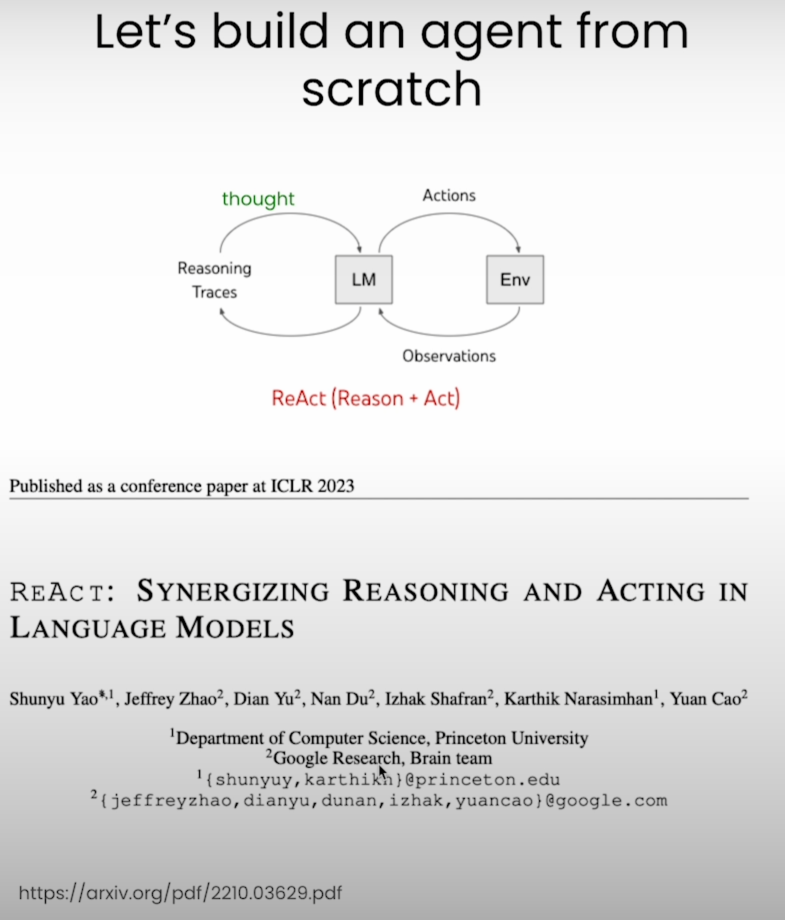

In [ ]:
#!pip install openai httpx python-dotenv

In [1]:
import openai
import re
import httpx
import os
import json
from dotenv import load_dotenv

_ = load_dotenv()
from openai import OpenAI

In [2]:
client = OpenAI()

In [3]:
chat_completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user", "content": "Hello world"}]
)

chat_completion

ChatCompletion(id='chatcmpl-9aLjKMz4o5HFCuWoYPfd28rUecY75', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Hello! How can I assist you today?', role='assistant', function_call=None, tool_calls=None))], created=1718450366, model='gpt-3.5-turbo-0125', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=9, prompt_tokens=9, total_tokens=18))

In [5]:
chat_completion.choices[0].message.content

'Hello! How can I assist you today?'

In [6]:
class Agent: # a generic agent
    def __init__(self, system=""):
        self.system = system # this allows user to specify a system role
        self.messages = [] # store the message history
        if self.system: # if there IS a system role set, we add it to the message history to start.
            self.messages.append({"role": "system", "content": system})

    def __call__(self, message):
        self.messages.append({"role": "user", "content": message})
        result = self.execute()
        self.messages.append({"role": "assistant", "content": result})
        return result

    def execute(self):
        completion = client.chat.completions.create(
                        model="gpt-4o", 
                        temperature=0,
                        messages=self.messages)
        return completion.choices[0].message.content
    

In [7]:
prompt = """
You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions.

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary

average_dog_weight:
e.g. average_dog_weight: Collie
returns average weight of a dog when given the breed

Example session:

Question: How much does a Bulldog weigh?
Thought: I should look the dogs weight using average_dog_weight
Action: average_dog_weight: Bulldog
PAUSE

You will be called again with this:

Observation: A Bulldog weights 51 lbs

You then output:

Answer: A bulldog weights 51 lbs
""".strip()

In [8]:
def calculate(what):
    return eval(what)

def average_dog_weight(name):
    if name in "Scottish Terrier": 
        return("Scottish Terriers average 20 lbs")
    elif name in "Border Collie":
        return("a Border Collies average weight is 37 lbs")
    elif name in "Toy Poodle":
        return("a toy poodles average weight is 7 lbs")
    else:
        return("An average dog weights 50 lbs")

known_actions = {
    "calculate": calculate,
    "average_dog_weight": average_dog_weight
}

In [9]:
abot = Agent(prompt)

In [10]:
result = abot("How much does a toy poodle weigh?")
print(result)

Thought: I should look up the average weight of a toy poodle using the average_dog_weight action.
Action: average_dog_weight: Toy Poodle
PAUSE


In [11]:
result = average_dog_weight("Toy Poodle")

In [12]:
result

'a toy poodles average weight is 7 lbs'

In [13]:
next_prompt = "Observation: {}".format(result)

In [14]:
abot(next_prompt)

'Answer: A toy poodle weighs an average of 7 lbs.'

In [15]:
abot.messages

[{'role': 'system',
  'content': 'You run in a loop of Thought, Action, PAUSE, Observation.\nAt the end of the loop you output an Answer\nUse Thought to describe your thoughts about the question you have been asked.\nUse Action to run one of the actions available to you - then return PAUSE.\nObservation will be the result of running those actions.\n\nYour available actions are:\n\ncalculate:\ne.g. calculate: 4 * 7 / 3\nRuns a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary\n\naverage_dog_weight:\ne.g. average_dog_weight: Collie\nreturns average weight of a dog when given the breed\n\nExample session:\n\nQuestion: How much does a Bulldog weigh?\nThought: I should look the dogs weight using average_dog_weight\nAction: average_dog_weight: Bulldog\nPAUSE\n\nYou will be called again with this:\n\nObservation: A Bulldog weights 51 lbs\n\nYou then output:\n\nAnswer: A bulldog weights 51 lbs'},
 {'role': 'user', 'content': 'How much does a 

In [16]:
abot = Agent(prompt)

In [17]:
question = """I have 2 dogs, a border collie and a scottish terrier. \
What is their combined weight"""
abot(question)

'Thought: I need to find the average weight of both a Border Collie and a Scottish Terrier, then sum these weights to get the combined weight of the two dogs.\nAction: average_dog_weight: Border Collie\nPAUSE'

In [18]:
next_prompt = "Observation: {}".format(average_dog_weight("Border Collie"))
print(next_prompt)

Observation: a Border Collies average weight is 37 lbs


In [19]:
abot(next_prompt)

'Thought: Now I need to find the average weight of a Scottish Terrier.\nAction: average_dog_weight: Scottish Terrier\nPAUSE'

In [20]:
next_prompt = "Observation: {}".format(average_dog_weight("Scottish Terrier"))
print(next_prompt)

Observation: Scottish Terriers average 20 lbs


In [21]:
abot(next_prompt)

'Thought: I now have the average weights of both dogs. I need to sum these weights to get the combined weight.\nAction: calculate: 37 + 20\nPAUSE'

In [22]:
next_prompt = "Observation: {}".format(eval("37 + 20"))
print(next_prompt)

Observation: 57


In [23]:
abot(next_prompt)

'Answer: The combined weight of a Border Collie and a Scottish Terrier is 57 lbs.'

In [27]:
action_re = re.compile('^Action: (\w+): (.*)$')   # python regular expression to selection action

<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_37408/2389047760.py:1: SyntaxWarning: invalid escape sequence '\w'
  action_re = re.compile('^Action: (\w+): (.*)$')   # python regular expression to selection action


In [25]:
def query(question, max_turns=5):
    i = 0
    bot = Agent(prompt)
    next_prompt = question
    while i < max_turns:
        i += 1
        result = bot(next_prompt)
        print(result)
        actions = [
            action_re.match(a) 
            for a in result.split('\n') 
            if action_re.match(a)
        ]
        if actions:
            # There is an action to run
            action, action_input = actions[0].groups()
            if action not in known_actions:
                raise Exception("Unknown action: {}: {}".format(action, action_input))
            print(" -- running {} {}".format(action, action_input))
            observation = known_actions[action](action_input)
            print("Observation:", observation)
            next_prompt = "Observation: {}".format(observation)
        else:
            return

In [28]:
question = """I have 2 dogs, a border collie and a scottish terrier. \
What is their combined weight"""
query(question)

Thought: I need to find the average weight of both a Border Collie and a Scottish Terrier, then add them together to get the combined weight.
Action: average_dog_weight: Border Collie
PAUSE
 -- running average_dog_weight Border Collie
Observation: a Border Collies average weight is 37 lbs
Thought: Now I need to find the average weight of a Scottish Terrier.
Action: average_dog_weight: Scottish Terrier
PAUSE
 -- running average_dog_weight Scottish Terrier
Observation: Scottish Terriers average 20 lbs
Thought: I now have the average weights of both dogs. I will add them together to find their combined weight.
Action: calculate: 37 + 20
PAUSE
 -- running calculate 37 + 20
Observation: 57
Answer: The combined weight of a Border Collie and a Scottish Terrier is 57 lbs.
